In [4]:
# Import stuff
import os
import scipy
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import theano

%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
figsize(11, 9)

In [5]:
this_dat = np.load('taste_data.npy')
print(this_dat.shape)
# Trial x Nrn x Time

(30, 10, 7000)


In [6]:
# Convert spikes to counts by binning
time_lims = [2000,4000]
bin_width = 10
t_vec = np.arange(this_dat.shape[-1])
binned_t_vec = np.mean(t_vec[time_lims[0]:time_lims[1]].reshape((-1,bin_width)),axis=-1)
this_dat_binned = np.sum(this_dat[...,time_lims[0]:time_lims[1]].reshape(*this_dat.shape[:2],-1,bin_width),axis=-1)
this_dat_binned = np.vectorize(np.int)(this_dat_binned)

(10, 200)


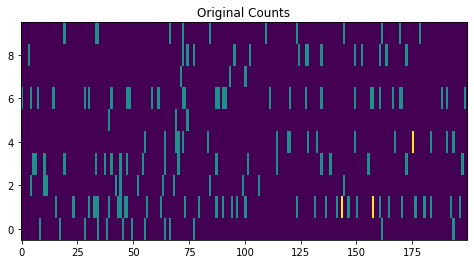

In [7]:
# Pick single trial
trial = 0
count_data = this_dat_binned[trial]
#count_data = np.sum(this_dat_binned,axis=0)
n_count_data = count_data.shape[-1]

plt.figure(figsize=(8,4))
plt.imshow((count_data>0)*1 + (count_data>1), interpolation = 'nearest', aspect = 'auto', origin = 'lower')
plt.title('Original Counts')

count_data = count_data>0
print(count_data.shape)
# Nrn X Time_bin

In [8]:
states = 2
split_list = np.array_split(count_data,states,axis=-1)
# Cut all to the same size
min_val = min([x.shape[-1] for x in split_list])
split_array = np.array([x[...,:min_val] for x in split_list])
print(split_array.shape)
mean_vals = np.mean(split_array,axis=-1)
mean_vals += 0.01 # To avoid zero starting prob
print(mean_vals)

(2, 10, 100)
[[0.12 0.2  0.11 0.14 0.07 0.04 0.18 0.03 0.06 0.07]
 [0.03 0.18 0.03 0.08 0.12 0.01 0.15 0.02 0.11 0.07]]


In [9]:
idx = np.arange(n_count_data) # Index
idx_range = idx.max() - idx.min()
print(idx.min())
print(idx.max())

0
199


In [113]:

lambda_names = ['lambda_{}'.format(i+1) for i in range(states)]
with pm.Model() as model:
    
    # Defining variables with priors
    #alpha = 1.0/count_data.mean(axis=-1)
    
    # Exponential prior on Poisson rate variable: for every state, for every neuron
    #lambda_1 = pm.Exponential("lambda_1", alpha, testval = mean_vals[0], shape = (count_data.shape[0]))
    #lambda_2 = pm.Exponential("lambda_2", alpha, testval = mean_vals[1], shape = (count_data.shape[0]))
    #lambda_3 = pm.Exponential("lambda_3", alpha, testval = mean_vals[1], shape = (count_data.shape[0]))
    
    # Finite, but somewhere on the lower end, Beta prior
    a_lambda = pm.HalfNormal('a_lambda', 2.)
    b_lambda = pm.HalfNormal('b_lambda', 5.)
    
    lambda_latent = pm.math.stack(
                        [pm.Beta(lambda_names[i], a_lambda, b_lambda, testval = mean_vals[i], 
                                   shape = (count_data.shape[0])) \
                         for i in range(states)]
    )
    
print(lambda_latent.tag.test_value.shape)
print(lambda_latent.tag.test_value)

(2, 10)
[[0.12 0.2  0.11 0.14 0.07 0.04 0.18 0.03 0.06 0.07]
 [0.03 0.18 0.03 0.08 0.12 0.01 0.15 0.02 0.11 0.07]]


In [114]:
even_switches = np.linspace(0,idx.max(),states+1)
even_switches_normal = even_switches/np.max(even_switches)
print(even_switches)
print(even_switches_normal[1:(states)])

[  0.   99.5 199. ]
[0.5]


In [115]:

with model:
    
    #tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data)
    
    # Scaled beta mixture "somewhere in the middle" prior
    #a1 = pm.HalfNormal('a_tau1', 3.)
    #b1 = pm.HalfNormal('b_tau1', 6.)
    #a2 = pm.HalfNormal('a_tau2', 3.)
    #b2 = pm.HalfNormal('b_tau2', 3.)
    #tau_latent1 = pm.Beta('tau_latent1', a1, b1)
    #tau_latent2 = pm.Beta('tau_latent2', a2, b2)
    #tau_1 = pm.Deterministic('tau_1', idx.min() + (idx.max() - idx.min()) * tau_latent1)
    #tau_2 = pm.Deterministic('tau_2', tau_1 + (idx.max() - idx.min()) * tau_latent2)
    #tau = pm.math.stack(tau_1,tau_2)
    
    a = pm.HalfNormal('a_tau', 3.)
    b = pm.HalfNormal('b_tau', 3.)
    
    # Define transforms
    Order = pm.transforms.Ordered() # The usual one that pymc3 automatically applies to bounded variables
    Logodd = pm.transforms.LogOdds() # So that one changepoint is always ahead of the other
    chain_tran = pm.transforms.Chain([Logodd, Order])
    if states > 2:
        tau_latent = pm.Beta('tau_latent', a, b,
                              shape = states-1, transform = chain_tran, testval = even_switches_normal[1:states])
    else:
        tau_latent = pm.Beta('tau_latent', a, b, testval = even_switches_normal[1])   
        
    tau = pm.Deterministic('tau', idx.min() + (idx.max() - idx.min()) * tau_latent)
    
    #tau = pm.DiscreteUniform('tau',lower = idx.min(),upper = idx.max(),
    #                         shape = states-1, transform = pm.transforms.Ordered())
    
    # Dirichlet distribution gives state lenghts
    #tau_latent = pm.Dirichlet('tau_latent', np.ones(states))[:3]
    # State lengths converted to switchpoint times
    #tau = pm.Deterministic('tau', idx_range * tt.extra_ops.cumsum(tau_latent)) # Gives end times of states
    
    
#print(tau_latent.tag.test_value)
print(tau.tag.test_value)
    


99.5


In [116]:
model.basic_RVs

[a_lambda_log__,
 b_lambda_log__,
 lambda_1_logodds__,
 lambda_2_logodds__,
 a_tau_log__,
 b_tau_log__,
 tau_latent_logodds__]

In [117]:
print(lambda_latent.tag.test_value)
print(tau.tag.test_value)


[[0.12 0.2  0.11 0.14 0.07 0.04 0.18 0.03 0.06 0.07]
 [0.03 0.18 0.03 0.08 0.12 0.01 0.15 0.02 0.11 0.07]]
99.5


In [118]:
# For single trial
#def binomial_likelihood(obs,tau_val,p_val):
"""
obs :: neuron x time
tau :: states - 1 (maybe float)
p   :: states x neuron
"""
obs = count_data
tau_val = tau.tag.test_value
p_val = lambda_latent.tag.test_value
# Convert tau to be integers
tau_int = np.vectorize(np.int)(tau_val)
print(p_val)

[[0.12 0.2  0.11 0.14 0.07 0.04 0.18 0.03 0.06 0.07]
 [0.03 0.18 0.03 0.08 0.12 0.01 0.15 0.02 0.11 0.07]]


In [119]:
tau_int_fin = np.sort(np.append(tau_int,[0,obs.shape[-1]]))
print(tau_int_fin)

[  0  99 200]


In [120]:
# Create index lists
index_list = [(tau_int_fin[i],tau_int_fin[i+1]) for i in range(len(tau_int_fin)-1)]
# Split array by index_list
array_list = [obs[...,ind[0]:ind[1]] for ind in index_list]
# Find total trials for every bin
n = [x.shape[-1] for x in array_list]
# Count successes in every bin
vals = [np.sum(x,axis=-1) for x in array_list] # list of states with 1xnrn vectors of p
vals_fin = np.stack(p)
n_fin = np.stack([np.ones(p[i].shape)*n[i] for i in range(len(n))])
p_fin = np.stack(p_val)
print(p_fin)
print(n_fin)
print(vals_fin)
print(n)
print(vals)
print(pm.math.sum(pm.Binomial.dist(n_fin,p_fin).logp(vals_fin)).tag.test_value)

[[0.12 0.2  0.11 0.14 0.07 0.04 0.18 0.03 0.06 0.07]
 [0.03 0.18 0.03 0.08 0.12 0.01 0.15 0.02 0.11 0.07]]
[[ 99.  99.  99.  99.  99.  99.  99.  99.  99.  99.]
 [101. 101. 101. 101. 101. 101. 101. 101. 101. 101.]]
[[11 19  9 13  6  3 17  2  5  6]
 [ 2 17  3  7 11  0 14  1 10  6]]
[99, 101]
[array([11, 19,  9, 13,  6,  3, 17,  2,  5,  6]), array([ 2, 17,  3,  7, 11,  0, 14,  1, 10,  6])]
-37.54454542981079


In [121]:
with model:
    
    # Assign lambdas to time_bin indices using sigmoids centered on switchpoints
    # Refer to https://www.desmos.com/calculator/yisbydv2cq
    
    #weight_0 = tt.nnet.sigmoid(2 * (idx - 0))
    
    # Define custom likelihood which will simply calculate the 
    # Binomial likelihood from the data
    
    # For single trial
    def binomial_likelihood(obs,tau_val,p_val):
        """
        obs :: neuron x time
        tau :: states - 1 (maybe float)
        p   :: states x neuron
        """
        obs = count_data
        tau_val = tau.tag.test_value
        p_val = lambda_latent.tag.test_value
        # Convert tau to be integers
        tau_int = np.vectorize(np.int)(tau_val)
        tau_int_fin = np.sort(np.append(tau_int,[0,obs.shape[-1]]))
        # Create index lists
        index_list = [(tau_int_fin[i],tau_int_fin[i+1]) for i in range(len(tau_int_fin)-1)]
        # Split array by index_list
        array_list = [obs[...,ind[0]:ind[1]] for ind in index_list]
        # Find total trials for every bin
        n = [x.shape[-1] for x in array_list]
        # Count successes in every bin
        vals = [np.sum(x,axis=-1) for x in array_list] # list of states with 1xnrn vectors of p
        vals_fin = np.stack(p)
        n_fin = np.stack([np.ones(p[i].shape)*n[i] for i in range(len(n))])
        p_fin = np.stack(p_val)
        return pm.Binomial.dist(n_fin,p_fin).logp(vals_fin)
        
        
    
    #weight_1 = tt.nnet.sigmoid(2 * (idx - tau)) # First state ends at tau[0]
    #weight_2 = tt.nnet.sigmoid(2 * (idx - tau[1])) # Second state ends at tau[1]
    #weight_3 = tt.nnet.sigmoid(2 * (idx - tau[2])) # Third state ends at tau[2]
    #weight_4 = tt.nnet.sigmoid(2 * (idx - tau[3])) # Fourth state ends at tau[3]
    #weight_5 = tt.nnet.sigmoid(2 * (idx - tau[4])) # Fourth state ends at tau[3]
    #weight_list = [tt.nnet.sigmoid(2 * (idx - tau[i])) for i in range(len(tau))]
    #weight_list = [tt.nnet.sigmoid(2 * (idx - 0)))] + weight_list
    
    #test = tt.as_tensor_variable(pm.math.stack([
    #                        1 - weight_1,
    #                        weight_1 * (1 - weight_2),
    #                        weight_2]))
    #print(test.tag.test_value.shape)
    #print(test.value)
    
    #test2 = np.matmul(test.T, lambda_latent)
    
    #lambda_ = pm.math.stack(
    #        [ ((1 - weight_1) * lambda_latent[0][i]) + \
    #          (weight_1 * lambda_latent[1][i])
    #         for i in range(count_data.shape[0])]
    #                )
    
    #lambda_ = pm.math.stack(
    #            [ ((1 - weight_1) * lambda_latent[0][i]) + \
    #              (weight_1 * (1 - weight_2) * lambda_latent[1][i]) + \
    #              (weight_2 * lambda_latent[2][i])
    #             for i in range(count_data.shape[0])]
    #                    )
    
    #lambda_ = pm.math.stack(
    #        [ (1 - weight_1) * lambda_latent[0][i] + \
    #          (weight_1  * lambda_latent[1][i]) #+ \
              #(weight_2 * (1 - weight_3) * lambda_latent[2][i]) + \
              #(weight_3 * (1 - weight_4) * lambda_latent[3][i]) + \
              #(weight_4 * (1 - weight_5) * lambda_latent[4][i]) + \
              #weight_5  * lambda_latent[5][i]
     #        for i in range(count_data.shape[0])]
     #               )
    
    #weight_vec = pm.math.stack([1 - weight_1,
    #                            weight_1 * (1 - weight_2),
    #                            weight_3])
    #print(weight_vec.T.tag.test_value.shape)
    #print(lambda_latent.T.tag.test_value.shape)
    #lambda_ = pm.math.stack(
    #                    theano.scan(fn = lambda nrn : weight_vec.T*nrn, sequences = [lambda_latent.T]))
    #lambda_ = pm.math.stack(pm.math.dot(weight_vec.T, lambda_latent[:,0]))
    

    
#print(lambda_.tag.test_value.shape)
#plt.imshow(lambda_.tag.test_value, aspect='auto',origin='lower');plt.colorbar();

In [122]:
# Using Bernoullo likelihood for count data
with model:
    #observation = pm.Bernoulli("obs", binomial_likelihood, observed=count_data)
    like = pm.DensityDist('obs', binomial_likelihood, observed=dict(obs=count_data,
                                                                    tau_val=tau,
                                                                    p_val=lambda_latent))

In [123]:
with model:
    trace = pm.sample(2000, tune=1000, chains = 8, cores = 8, target_accept = 0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [tau_latent, b_tau, a_tau, lambda_2, lambda_1, b_lambda, a_lambda]
Sampling 8 chains, 252 divergences: 100%|██████████| 24000/24000 [00:15<00:00, 1551.91draws/s]
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7854339373305221, but should be close to 0.9. Try to increase the number of tuning steps.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It 

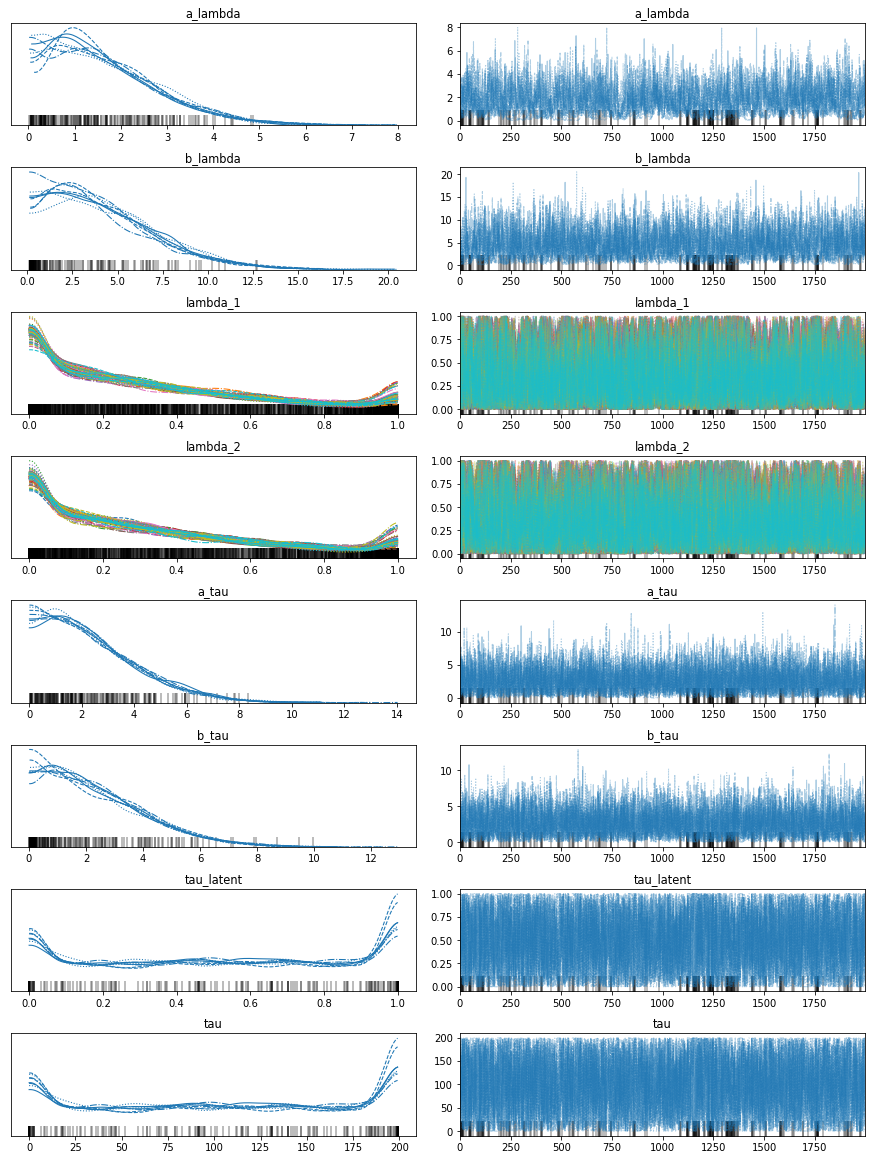

In [124]:
pm.traceplot(trace);

In [125]:
pm.summary(trace).round(2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a_lambda,1.68,1.17,0.02,3.78,0.04,0.03,698.0,698.0,457.0,325.0,1.01
b_lambda,4.25,2.96,0.14,9.59,0.06,0.04,2215.0,2215.0,1286.0,885.0,1.01
lambda_1[0],0.33,0.28,0.00,0.88,0.01,0.01,1117.0,1117.0,739.0,590.0,1.01
lambda_1[1],0.32,0.28,0.00,0.87,0.01,0.01,1064.0,1064.0,739.0,728.0,1.01
lambda_1[2],0.32,0.28,0.00,0.88,0.01,0.01,1102.0,1102.0,727.0,638.0,1.01
lambda_1[3],0.32,0.28,0.00,0.87,0.01,0.01,1092.0,1092.0,726.0,594.0,1.01
lambda_1[4],0.33,0.28,0.00,0.88,0.01,0.01,1075.0,1075.0,751.0,667.0,1.01
lambda_1[5],0.32,0.28,0.00,0.87,0.01,0.01,1102.0,1102.0,772.0,695.0,1.01
lambda_1[6],0.32,0.28,0.00,0.88,0.01,0.01,1025.0,1025.0,722.0,602.0,1.01
lambda_1[7],0.33,0.28,0.00,0.88,0.01,0.01,1075.0,1075.0,726.0,590.0,1.01


In [226]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
#lambda_3_samples = trace['lambda_3']
#lambda_4_samples = trace['lambda_4']
lambda_stack = np.stack([lambda_1_samples,
                            lambda_2_samples])#,
                            #lambda_3_samples])#,
                            #lambda_4_samples])
#tau_1_samples = trace['tau_1']
#tau_2_samples = trace['tau_2']
#tau_samples = np.stack([tau_1_samples, tau_2_samples])
tau_samples = trace['tau']
print(tau_samples.shape)
print(lambda_stack.shape)

(40000,)
(2, 40000, 10)


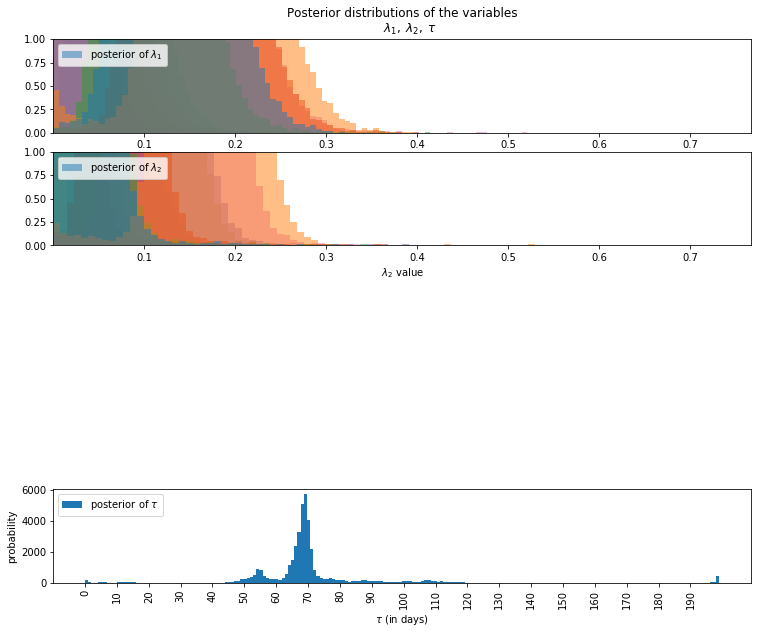

In [227]:
figsize(12.5, 10)
#histogram of the samples:

ax = plt.subplot(511)
ax.set_autoscaley_on(False)

x_lims = [min(lambda_stack.flatten()),max(lambda_stack.flatten())]
bin_num = 100

plt.hist(lambda_1_samples, histtype='stepfilled', bins=bin_num, alpha=0.5,
         label="posterior of $\lambda_1$", density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlabel("$\lambda_1$ value")
plt.xlim(x_lims)

ax = plt.subplot(512)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=bin_num, alpha=0.5,
         label="posterior of $\lambda_2$", density=True)
plt.legend(loc="upper left")
plt.xlabel("$\lambda_2$ value")
plt.xlim(x_lims)

#ax = plt.subplot(513)
#ax.set_autoscaley_on(False)
#plt.hist(lambda_3_samples, histtype='stepfilled', bins=bin_num, alpha=0.5,
#         label="posterior of $\lambda_2$", density=True)
#plt.legend(loc="upper left")
#plt.xlabel("$\lambda_2$ value")
#plt.xlim(x_lims)

#ax = plt.subplot(514)
#ax.set_autoscaley_on(False)
#plt.hist(lambda_4_samples, histtype='stepfilled', bins=bin_num, alpha=0.5,
#         label="posterior of $\lambda_2$", density=True)
#plt.legend(loc="upper left")
#plt.xlabel("$\lambda_2$ value")
#plt.xlim(x_lims)

plt.subplot(515)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
        rwidth=2.)
plt.xticks(np.arange(n_count_data,step=10))



plt.legend(loc="upper left")
plt.xlabel(r"$\tau$ (in days)")
plt.xticks(rotation='vertical')
plt.ylabel("probability");

In [228]:
ppc = pm.sample_posterior_predictive(trace, samples = 2000, model = model)
ppc['obs'].shape

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 2000/2000 [00:03<00:00, 511.46it/s]


(2000, 10, 200)

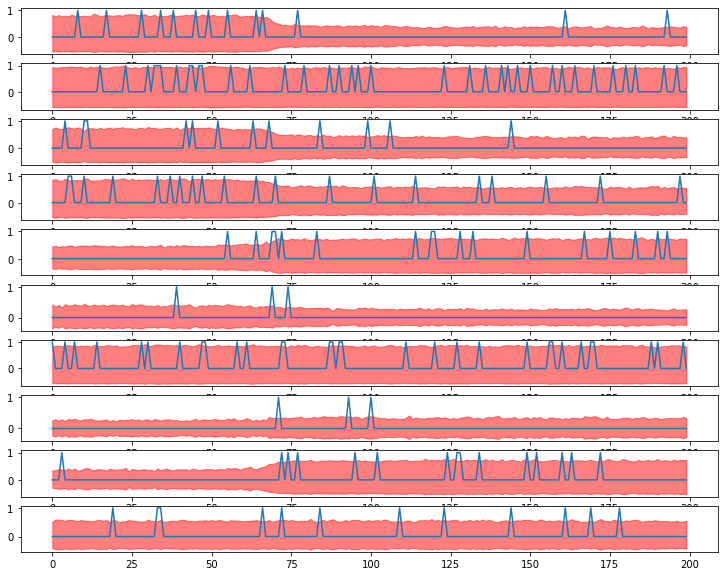

In [229]:
mean_ppc = np.mean(ppc['obs'],axis=0)
std_ppc = np.std(ppc['obs'],axis=0)

x = np.arange(count_data.shape[-1])
fig, ax = plt.subplots(count_data.shape[0],1, sharey = False)
for num,(nrn,this_ax) in enumerate(zip(count_data, ax.flatten())):
    this_ax.plot(x,nrn);
    this_ax.fill_between( x = x,
                        y1 = mean_ppc[num] + 2*std_ppc[num],
                        y2 = mean_ppc[num] - 2*std_ppc[num],
                        color = 'red', alpha = 0.5);
#plt.plot(np.mean(ppc['obs'],axis=0));
#traces = 100
#plt.plot(ppc['obs'][:100].T, alpha = 0.05);

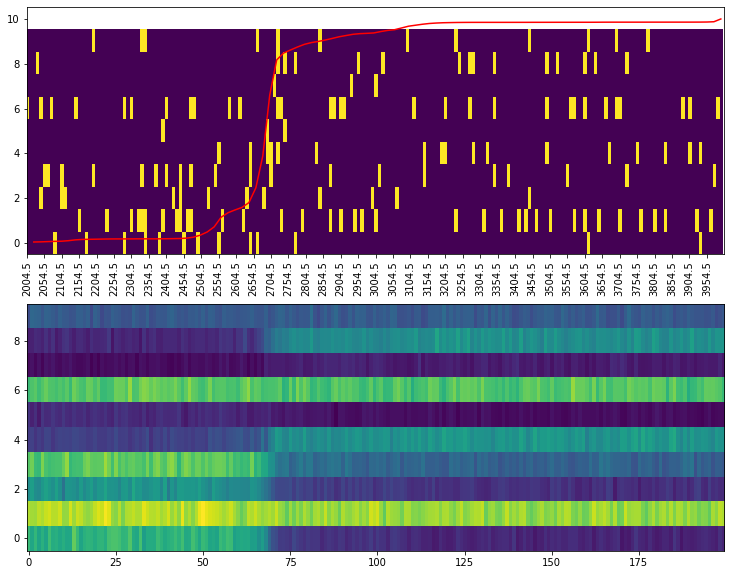

In [230]:
# Overlay raster with CDF of switchpoints
ax = plt.subplot(211)
plt.imshow(count_data,interpolation='nearest',aspect='auto',origin='lower')
tick_interval = 5
fin_prob,this_x = np.histogram(tau_samples.flatten(),100)
cum_prob = np.cumsum(fin_prob)
plt.plot(this_x[1:],cum_prob/np.max(cum_prob)*count_data.shape[0], c = 'red');
plt.xticks(np.arange(0,len(binned_t_vec),tick_interval),binned_t_vec[::tick_interval],rotation='vertical');
plt.xlim(0,len(binned_t_vec))

ax = plt.subplot(212)
plt.imshow(mean_ppc, aspect='auto',origin='lower')